# This Notebook is about application of different TF2 callbacks method on a Time Series forecasting problem 

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install tf-nightly-2.0-preview

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
print(tf.__version__)

2.3.1


## A simulated Time Series 

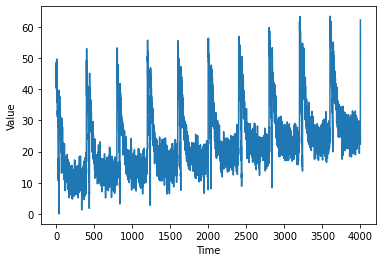

In [60]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 400 + 1, dtype="float32")
time_period = 4000
baseline = 10
series = trend(time, 0.05)  
baseline = 10
amplitude = 35
slope = 0.004
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=400, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3350
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

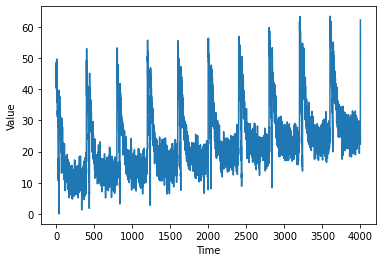

In [65]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 400 + 1, dtype="float32")
time_period = 4000
baseline = 10
series = trend(time, 0.05)  
baseline = 10
amplitude = 35
slope = 0.004
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=400, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3350
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plot_series(time, series)

## A ballpark prediction using MA 

In [6]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

Mean Squared Error: 45.56762


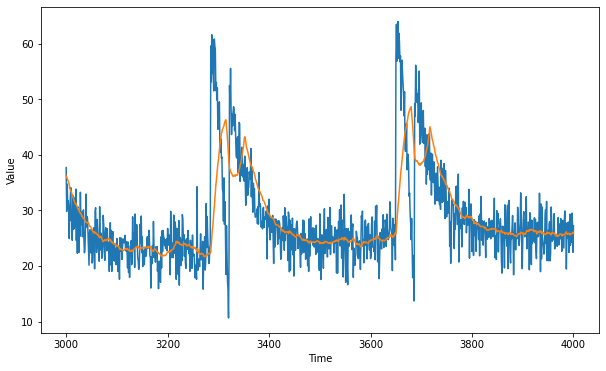

In [13]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
print('Mean Squared Error:', tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())

## A benchmark ARIMA model

Test MSE: 21.882


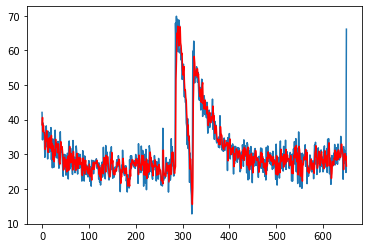

In [21]:
# 
# model = ARIMA(x_train, order=(2,1,0))
# model_fit = model.fit()
# print(model_fit.summary())
# # line plot of residuals
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()
# # density plot of residuals
# residuals.plot(kind='kde')
# plt.show()
# # summary stats of residuals
# print(residuals.describe())
history = [x for x in x_train]
predictions = list()
for t in range(len(x_valid)):
	model = ARIMA(history, order=(2,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = x_valid[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
mse = mean_squared_error(x_valid, predictions)
print('Test MSE: %.3f' % mse)
# plot forecasts against actual outcomes
plt.plot(x_valid)
plt.plot(predictions, color='red')
plt.show()

## Preparing data for Tensorflow model

In [3]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

### Model architechture- 2 layer Bidirectional LSTM  

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
model.summary()

In [4]:
def lstm_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
    return model
model = lstm_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


## Different TF2 callback functions

### A) Model Checkpoint- Periodic Archival

In [37]:
checkpoint_filepath = 'model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)
# Model weights are saved at the end of every epoch, if it's the best seen so far.
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
model.fit(dataset,validation_data=valid_dataset,epochs=100, callbacks=[model_checkpoint_callback])
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/100
94/94 [==============================] - 3s 33ms/step - loss: 8.7951 - mse: 194.1176 - val_loss: 4.1761 - val_mse: 60.2800
Epoch 2/100
94/94 [==============================] - 2s 18ms/step - loss: 4.3077 - mse: 63.9079 - val_loss: 3.5077 - val_mse: 46.9988
Epoch 3/100
94/94 [==============================] - 2s 21ms/step - loss: 4.1678 - mse: 59.5302 - val_loss: 3.3846 - val_mse: 43.8238
Epoch 4/100
94/94 [==============================] - 2s 22ms/step - loss: 4.0635 - mse: 56.1141 - val_loss: 3.2820 - val_mse: 41.0425
Epoch 5/100
94/94 [==============================] - 2s 20ms/step - loss: 3.9554 - mse: 53.4834 - val_loss: 3.2358 - val_mse: 39.8581
Epoch 6/100
94/94 [==============================] - 2s 19ms/step - loss: 3.8736 - mse: 51.1861 - val_loss: 3.2210 - val_mse: 39.2600
Epoch 7/100
94/94 [==============================] - 2s 19ms/step - loss: 3.8008 - mse: 49.4137 - val_loss: 3.1746 - val_mse: 38.0684
Epoch 8/100
94/94 [==============================] - 2s 21ms/

### B) Standard tensorflow early_stopping callback

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
early_stopping = EarlyStopping(
    monitor='val_mse', min_delta=0.01,
    patience=5, 
    mode='min'
)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
history = model.fit(dataset,validation_data=valid_dataset,epochs=1000,callbacks=[early_stopping])

Epoch 1/1000
94/94 [==============================] - 4s 44ms/step - loss: 6.5822 - mse: 135.1942 - val_loss: 4.6915 - val_mse: 82.3511
Epoch 2/1000
94/94 [==============================] - 2s 26ms/step - loss: 5.4479 - mse: 104.3948 - val_loss: 4.1136 - val_mse: 67.5268
Epoch 3/1000
94/94 [==============================] - 3s 31ms/step - loss: 5.1453 - mse: 93.4558 - val_loss: 3.9336 - val_mse: 62.2269
Epoch 4/1000
94/94 [==============================] - 2s 26ms/step - loss: 4.9672 - mse: 86.5482 - val_loss: 3.7708 - val_mse: 57.6155
Epoch 5/1000
94/94 [==============================] - 2s 23ms/step - loss: 4.8074 - mse: 80.7610 - val_loss: 3.7114 - val_mse: 55.4904
Epoch 6/1000
94/94 [==============================] - 2s 22ms/step - loss: 4.6809 - mse: 76.2318 - val_loss: 3.5956 - val_mse: 51.8265
Epoch 7/1000
94/94 [==============================] - 2s 22ms/step - loss: 4.5649 - mse: 71.5008 - val_loss: 3.6469 - val_mse: 52.4040
Epoch 8/1000
94/94 [==============================] -

#### Monitoring the metrics

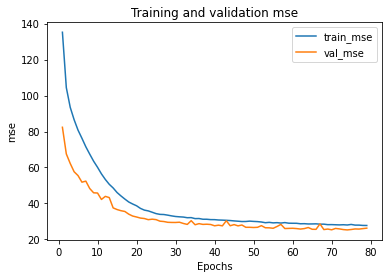

In [22]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
#     plt.axis([65,80,25,29])
    plt.show()
plot_metric(history, 'mse')

#### Zooming in

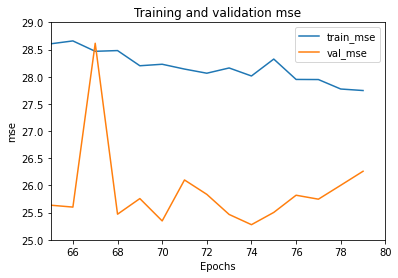

In [23]:
def plot_metric(history, metric,zoom_range):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.axis(zoom_range)
    plt.show()
plot_metric(history, 'mse',zoom_range = [65,80,25,29])

### C)ReduceLROnPlateau.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5,verbose =1, min_lr=0.0001)
history = model.fit(dataset,validation_data=valid_dataset,epochs=1000,callbacks=[reduce_lr],verbose=1)

In [18]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5,verbose =1, min_lr=0.0001)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(dataset,validation_data=valid_dataset,epochs=1000,callbacks=[reduce_lr],verbose=1)

Epoch 1/1000
94/94 [==============================] - 4s 40ms/step - loss: 27.7605 - mse: 883.6899 - val_loss: 23.5157 - val_mse: 621.6388
Epoch 2/1000
94/94 [==============================] - 3s 28ms/step - loss: 25.3147 - mse: 742.2054 - val_loss: 20.9918 - val_mse: 499.3093
Epoch 3/1000
94/94 [==============================] - 3s 28ms/step - loss: 22.9849 - mse: 616.6191 - val_loss: 18.6211 - val_mse: 395.4025
Epoch 4/1000
94/94 [==============================] - 3s 28ms/step - loss: 20.8126 - mse: 508.7144 - val_loss: 16.3938 - val_mse: 309.4088
Epoch 5/1000
94/94 [==============================] - 3s 28ms/step - loss: 18.7824 - mse: 416.1371 - val_loss: 14.2307 - val_mse: 237.5384
Epoch 6/1000
94/94 [==============================] - 3s 28ms/step - loss: 16.8478 - mse: 337.5496 - val_loss: 12.1592 - val_mse: 179.6177
Epoch 7/1000
94/94 [==============================] - 3s 28ms/step - loss: 14.9883 - mse: 271.6607 - val_loss: 10.1766 - val_mse: 134.5589
Epoch 8/1000
94/94 [=======

## D)custom callback

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
class custom_Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_mse')<21.882):
            print("\n MSE Reached less than benchmark model so cancelling training!")
            self.model.stop_training = True

callback = custom_Callback()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
history = model.fit(dataset,validation_data=valid_dataset,epochs=1000,callbacks=[callback])

Epoch 1/1000
94/94 [==============================] - 7s 25ms/step - loss: 7.1306 - mse: 139.6298 - val_loss: 4.6915 - val_mse: 82.3511
Epoch 2/1000
94/94 [==============================] - 1s 14ms/step - loss: 5.5043 - mse: 104.0807 - val_loss: 4.1136 - val_mse: 67.5267
Epoch 3/1000
94/94 [==============================] - 1s 14ms/step - loss: 5.1356 - mse: 90.7115 - val_loss: 3.9336 - val_mse: 62.2269
Epoch 4/1000
94/94 [==============================] - 1s 13ms/step - loss: 4.7889 - mse: 79.4682 - val_loss: 3.7708 - val_mse: 57.6155
Epoch 5/1000
94/94 [==============================] - 1s 15ms/step - loss: 4.7919 - mse: 79.2126 - val_loss: 3.7114 - val_mse: 55.4904
Epoch 6/1000
94/94 [==============================] - 1s 14ms/step - loss: 4.6843 - mse: 73.1491 - val_loss: 3.5956 - val_mse: 51.8265
Epoch 7/1000
94/94 [==============================] - 1s 14ms/step - loss: 4.4675 - mse: 67.5138 - val_loss: 3.6469 - val_mse: 52.4040
Epoch 8/1000
94/94 [==============================] -

### E) learning rate scheduler

#### Finding optimum learning rate

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 3s 28ms/step - loss: 7.9720 - mse: 126.1153
Epoch 2/100
94/94 [==============================] - 2s 27ms/step - loss: 7.4435 - mse: 122.7911
Epoch 3/100
94/94 [==============================] - 3s 29ms/step - loss: 7.0863 - mse: 121.8583
Epoch 4/100
94/94 [==============================] - 3s 33ms/step - loss: 6.8533 - mse: 121.9274
Epoch 5/100
94/94 [==============================] - 2s 26ms/step - loss: 6.7007 - mse: 122.0661: 1s - loss: - ETA: 0s - loss: 6.5486 - 
Epoch 6/100
94/94 [==============================] - 3s 27ms/step - loss: 6.5929 - mse: 122.0629: 1s 
Epoch 7/100
94/94 [==============================] - 2s 27ms/step - loss: 6.5043 - mse: 121.3454
Epoch 8/100
94/94 [==============================] - 2s 26ms/step - loss: 6.4261 - mse: 120.7031
Epoch 9/100
94/94 [==============================] - 2s 26ms/step - loss: 6.3492 - mse: 118.8680
Epoch 10/100
94/94 [==============================] - 2s 26ms/step - loss: 6.2716 

(1e-08, 0.0001, 20.0, 130.0)

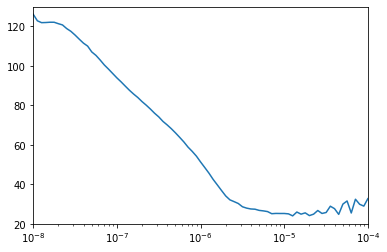

In [25]:
plt.semilogx(history.history["lr"], history.history["mse"])
plt.axis([1e-8, 1e-4, 20, 130])

# FROM THIS PICK A LEARNING RATE

### F) Custom callback coupled with learning rate scheduler

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
class custom_Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_mse')<21.882):
            print("\n MSE Reached less than benchmark model so cancelling training!")
            self.model.stop_training = True

callback = custom_Callback()

history = model.fit(dataset,validation_data=valid_dataset,epochs=1000,callbacks=[callback,model_checkpoint_callback])
                                                            

Epoch 1/1000
94/94 [==============================] - 3s 32ms/step - loss: 8.9126 - mse: 243.4540 - val_loss: 4.7290 - val_mse: 63.4280
Epoch 2/1000
94/94 [==============================] - 2s 19ms/step - loss: 4.0722 - mse: 50.9349 - val_loss: 3.1597 - val_mse: 33.9960
Epoch 3/1000
94/94 [==============================] - 2s 19ms/step - loss: 3.3364 - mse: 37.5241 - val_loss: 4.1685 - val_mse: 37.9998
Epoch 4/1000
94/94 [==============================] - 2s 19ms/step - loss: 3.2678 - mse: 34.6144 - val_loss: 3.2366 - val_mse: 33.8311
Epoch 5/1000
94/94 [==============================] - 2s 19ms/step - loss: 3.0756 - mse: 31.6519 - val_loss: 2.8661 - val_mse: 28.0971
Epoch 6/1000
94/94 [==============================] - 2s 19ms/step - loss: 3.0173 - mse: 30.4490 - val_loss: 2.9843 - val_mse: 26.7707
Epoch 7/1000
94/94 [==============================] - 2s 19ms/step - loss: 3.0343 - mse: 30.1065 - val_loss: 2.9203 - val_mse: 26.0621
Epoch 8/1000
94/94 [==============================] - 

### Assessing Forecasting quality

21.58956

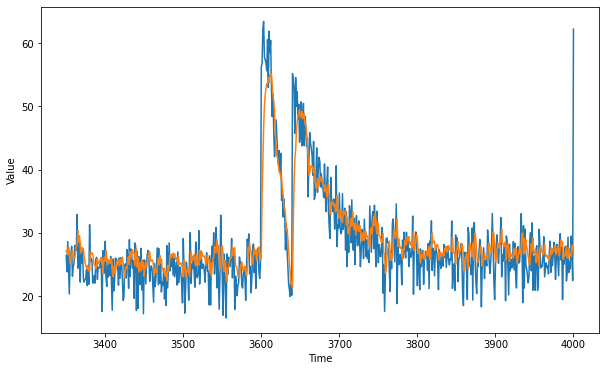

In [56]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print('Validation MSE:',tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

In [57]:
print('Validation MSE:',tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

Validation MSE: 21.58956


## So there is a 1.35% of improvement in validation MSE over the benchmark ARIMA model

## Thanks You 